In [1]:
import os
from sys import stdout
from tqdm import tqdm
from timeit import default_timer as timer

os.environ["OMP_NUM_THREADS"] = "1"  # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "1"  # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1"  # export NUMEXPR_NUM_THREADS=6

import numpy as np
import sisl
from src.grogu_magn.useful import *
from mpi4py import MPI
from numpy.linalg import inv
import warnings

# runtime information
times = dict()
times["start_time"] = timer()

[Mac:57824] shmem: mmap: an error occurred while determining whether or not /var/folders/yh/dx7xl94n3g52ts3td8qcxjcc0000gn/T//ompi.Mac.501/jf.0/1921449984/sm_segment.Mac.501.72870000.0 could be created.


In [2]:
# this cell mimicks an input file
fdf = sisl.get_sile("./lat3_791/Fe3GeTe2.fdf")
# this information needs to be given at the input!!
scf_xcf_orientation = np.array([0, 0, 1])  # z
# list of reference directions for around which we calculate the derivatives
# o is the quantization axis, v and w are two axes perpendicular to it
# at this moment the user has to supply o,v,w on the input.
# we can have some default for this
ref_xcf_orientations = [
    dict(o=np.array([1, 0, 0]), vw=[np.array([0, 1, 0]), np.array([0, 0, 1])]),
    dict(o=np.array([0, 1, 0]), vw=[np.array([1, 0, 0]), np.array([0, 0, 1])]),
    dict(o=np.array([0, 0, 1]), vw=[np.array([1, 0, 0]), np.array([0, 1, 0])]),
]

# human readable definition of magnetic entities
magnetic_entities = [
    dict(atom=3, l=2),
    dict(atom=4, l=2),
    dict(atom=5, l=2),
    dict(
        atom=[3, 4],
    ),
]

# pair information
pairs = [
    dict(ai=0, aj=1, Ruc=np.array([0, 0, 0])),  # isotropic should be -82 meV
    dict(
        ai=0, aj=2, Ruc=np.array([0, 0, 0])
    ),  # these should all be around -41.9 in the isotropic part
    dict(ai=1, aj=2, Ruc=np.array([0, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([-1, 0, 0])),
    dict(ai=1, aj=2, Ruc=np.array([-1, 0, 0])),
]


# Brilloun zone sampling and Green function contour integral
kset = 20
kdirs = "xy"
ebot = -30
eset = 50
esetp = 10000


# MPI parameters
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
root_node = 0
if rank == root_node:
    print("Number of nodes in the parallel cluster: ", size)

simulation_parameters = dict(
    path="Not yet specified.",
    scf_xcf_orientation=scf_xcf_orientation,
    ref_xcf_orientations=ref_xcf_orientations,
    kset=kset,
    kdirs=kdirs,
    ebot=ebot,
    eset=eset,
    esetp=esetp,
    parallel_size=size,
)

# digestion of the input
# read in hamiltonian
dh = fdf.read_hamiltonian()
try:
    simulation_parameters["geom"] = fdf.read_geometry()
except:
    print("Error reading geometry.")

# unit cell index
uc_in_sc_idx = dh.lattice.sc_index([0, 0, 0])

times["setup_time"] = timer()

Number of nodes in the parallel cluster:  1


In [3]:
NO = dh.no  # shorthand for number of orbitals in the unit cell

# preprocessing Hamiltonian and overlap matrix elements
h11 = dh.tocsr(dh.M11r)
h11 += dh.tocsr(dh.M11i) * 1.0j
h11 = h11.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h22 = dh.tocsr(dh.M22r)
h22 += dh.tocsr(dh.M22i) * 1.0j
h22 = h22.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h12 = dh.tocsr(dh.M12r)
h12 += dh.tocsr(dh.M12i) * 1.0j
h12 = h12.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h21 = dh.tocsr(dh.M21r)
h21 += dh.tocsr(dh.M21i) * 1.0j
h21 = h21.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

sov = (
    dh.tocsr(dh.S_idx)
    .toarray()
    .reshape(NO, dh.n_s, NO)
    .transpose(0, 2, 1)
    .astype("complex128")
)


# Reorganization of Hamiltonian and overlap matrix elements to SPIN BOX representation
U = np.vstack(
    [np.kron(np.eye(NO, dtype=int), [1, 0]), np.kron(np.eye(NO, dtype=int), [0, 1])]
)
# This is the permutation that transforms ud1ud2 to u12d12
# That is this transforms FROM SPIN BOX to ORBITAL BOX => U
# the inverse transformation is U.T u12d12 to ud1ud2
# That is FROM ORBITAL BOX to SPIN BOX => U.T

# From now on everything is in SPIN BOX!!
hh, ss = np.array(
    [
        U.T @ np.block([[h11[:, :, i], h12[:, :, i]], [h21[:, :, i], h22[:, :, i]]]) @ U
        for i in range(dh.lattice.nsc.prod())
    ]
), np.array(
    [
        U.T
        @ np.block([[sov[:, :, i], sov[:, :, i] * 0], [sov[:, :, i] * 0, sov[:, :, i]]])
        @ U
        for i in range(dh.lattice.nsc.prod())
    ]
)


# symmetrizing Hamiltonian and overlap matrix to make them hermitian
for i in range(dh.lattice.sc_off.shape[0]):
    j = dh.lattice.sc_index(-dh.lattice.sc_off[i])
    h1, h1d = hh[i], hh[j]
    hh[i], hh[j] = (h1 + h1d.T.conj()) / 2, (h1d + h1.T.conj()) / 2
    s1, s1d = ss[i], ss[j]
    ss[i], ss[j] = (s1 + s1d.T.conj()) / 2, (s1d + s1.T.conj()) / 2

# identifying TRS and TRB parts of the Hamiltonian
TAUY = np.kron(np.eye(NO), tau_y)
hTR = np.array([TAUY @ hh[i].conj() @ TAUY for i in range(dh.lattice.nsc.prod())])
hTRS = (hh + hTR) / 2
hTRB = (hh - hTR) / 2

# extracting the exchange field
traced = [spin_tracer(hTRB[i]) for i in range(dh.lattice.nsc.prod())]  # equation 77
XCF = np.array(
    [
        np.array([f["x"] for f in traced]),
        np.array([f["y"] for f in traced]),
        np.array([f["z"] for f in traced]),
    ]
)  # equation 77

# Check if exchange field has scalar part
max_xcfs = abs(np.array(np.array([f["c"] for f in traced]))).max()
if max_xcfs > 1e-12:
    warnings.warn(
        f"Exchange field has non negligible scalar part. Largest value is {max_xcfs}"
    )

times["H_and_XCF_time"] = timer()

In [4]:
# for every site we have to store 3 Greens function (and the associated _tmp-s) in the 3 reference directions
for i, mag_ent in enumerate(magnetic_entities):
    parsed = parse_magnetic_entity(dh, **mag_ent)  # parse orbital indexes
    magnetic_entities[i]["orbital_indeces"] = parsed
    # calculate spin box indexes
    magnetic_entities[i]["spin_box_indeces"] = blow_up_orbindx(parsed)
    # calculate size for Greens function generation
    spin_box_shape = len(mag_ent["spin_box_indeces"])

    mag_ent["energies"] = []  # we will store the second order energy derivations here

    mag_ent["Gii"] = []  # Greens function
    mag_ent["Gii_tmp"] = []  # Greens function for parallelization
    # These will be the perturbed potentials from eq. 100
    mag_ent["Vu1"] = [list([]) for _ in range(len(ref_xcf_orientations))]
    mag_ent["Vu2"] = [list([]) for _ in range(len(ref_xcf_orientations))]
    for i in ref_xcf_orientations:
        # Greens functions for every quantization axis
        mag_ent["Gii"].append(
            np.zeros((eset, spin_box_shape, spin_box_shape), dtype="complex128")
        )
        mag_ent["Gii_tmp"].append(
            np.zeros((eset, spin_box_shape, spin_box_shape), dtype="complex128")
        )

# for every site we have to store 2x3 Greens function (and the associated _tmp-s)
# in the 3 reference directions, because G_ij and G_ji are both needed
for pair in pairs:
    # calculate size for Greens function generation
    spin_box_shape_i = len(magnetic_entities[pair["ai"]]["spin_box_indeces"])
    spin_box_shape_j = len(magnetic_entities[pair["aj"]]["spin_box_indeces"])

    pair["energies"] = []  # we will store the second order energy derivations here

    pair["Gij"] = []  # Greens function
    pair["Gji"] = []
    pair["Gij_tmp"] = []  # Greens function for parallelization
    pair["Gji_tmp"] = []
    for i in ref_xcf_orientations:
        # Greens functions for every quantization axis
        pair["Gij"].append(
            np.zeros((eset, spin_box_shape_i, spin_box_shape_j), dtype="complex128")
        )
        pair["Gij_tmp"].append(
            np.zeros((eset, spin_box_shape_i, spin_box_shape_j), dtype="complex128")
        )
        pair["Gji"].append(
            np.zeros((eset, spin_box_shape_j, spin_box_shape_i), dtype="complex128")
        )
        pair["Gji_tmp"].append(
            np.zeros((eset, spin_box_shape_j, spin_box_shape_i), dtype="complex128")
        )

times["site_and_pair_dictionaries_time"] = timer()

In [5]:
kset = make_kset(dirs=kdirs, NUMK=kset)  # generate k space sampling
wkset = np.ones(len(kset)) / len(kset)  # generate weights for k points
kpcs = np.array_split(kset, size)  # split the k points based on MPI size
kpcs[root_node] = tqdm(kpcs[root_node], desc="k loop", file=stdout)

times["k_set_time"] = timer()

k loop:   0%|          | 0/400 [00:00<?, ?it/s]

In [6]:
# this will contain the three hamiltonians in the reference directions needed to calculate the energy variations upon rotation
hamiltonians = []

# iterate over the reference directions (quantization axes)
for i, orient in enumerate(ref_xcf_orientations):
    # obtain rotated exchange field
    R = RotMa2b(scf_xcf_orientation, orient["o"])
    rot_XCF = np.einsum("ij,jklm->iklm", R, XCF)
    rot_H_XCF = sum(
        [np.kron(rot_XCF[i], tau) for i, tau in enumerate([tau_x, tau_y, tau_z])]
    )
    rot_H_XCF_uc = rot_H_XCF[uc_in_sc_idx]

    # obtain total Hamiltonian with the rotated exchange field
    rot_H = (
        hTRS + rot_H_XCF
    )  # equation 76 #######################################################################################

    hamiltonians.append(
        dict(orient=orient["o"], H=rot_H)
    )  # store orientation and rotated Hamiltonian

    # these are the infinitezimal rotations (for now) perpendicular to the quantization axis
    for u in orient["vw"]:
        Tu = np.kron(np.eye(NO, dtype=int), tau_u(u))  # section 2.H

        Vu1 = 1j / 2 * commutator(rot_H_XCF_uc, Tu)  # equation 100
        Vu2 = 1 / 8 * commutator(commutator(Tu, rot_H_XCF_uc), Tu)  # equation 100

        for mag_ent in magnetic_entities:
            # fill up the perturbed potentials (for now) based on the on-site projections
            mag_ent["Vu1"][i].append(
                Vu1[:, mag_ent["spin_box_indeces"]][mag_ent["spin_box_indeces"], :]
            )
            mag_ent["Vu2"][i].append(
                Vu2[:, mag_ent["spin_box_indeces"]][mag_ent["spin_box_indeces"], :]
            )

times["reference_rotations_time"] = timer()

In [7]:
if rank == root_node:
    print("Number of magnetic entities being calculated: ", len(magnetic_entities))
    print(
        "We have to calculate the Greens function for three reference direction and we are going to calculate 15 energy integrals per site."
    )
    print(f"The shape of the Hamiltonian and the Greens function is {NO}x{NO}.")
comm.Barrier()
# ----------------------------------------------------------------------

# make energy contour
# we are working in eV now  !
# and sisil shifts E_F to 0 !
cont = make_contour(emin=ebot, enum=eset, p=esetp)
eran = cont.ze

# ----------------------------------------------------------------------
# sampling the integrand on the contour and the BZ
for k in kpcs[rank]:
    wk = wkset[rank]  # weight of k point in BZ integral
    # iterate over reference directions
    for i, hamiltonian_orientation in enumerate(hamiltonians):
        # calculate Greens function
        H = hamiltonian_orientation["H"]
        HK, SK = hsk(H, ss, dh.sc_off, k)
        Gk = inv(SK * eran.reshape(eset, 1, 1) - HK)

        # store the Greens function slice of the magnetic entities (for now) based on the on-site projections
        for mag_ent in magnetic_entities:
            mag_ent["Gii_tmp"][i] += (
                Gk[:, mag_ent["spin_box_indeces"]][..., mag_ent["spin_box_indeces"]]
                * wk
            )

        for pair in pairs:
            # add phase shift based on the cell difference
            phase = np.exp(1j * 2 * np.pi * k @ pair["Ruc"].T)

            # get the pair orbital sizes from the magnetic entities
            ai = magnetic_entities[pair["ai"]]["spin_box_indeces"]
            aj = magnetic_entities[pair["aj"]]["spin_box_indeces"]

            # store the Greens function slice of the magnetic entities (for now) based on the on-site projections
            pair["Gij_tmp"][i] += Gk[:, ai][..., aj] * phase * wk
            pair["Gji_tmp"][i] += Gk[:, aj][..., ai] * phase * wk

# summ reduce partial results of mpi nodes
for i in range(len(hamiltonians)):
    for mag_ent in magnetic_entities:
        comm.Reduce(mag_ent["Gii_tmp"][i], mag_ent["Gii"][i], root=root_node)

    for pair in pairs:
        comm.Reduce(pair["Gij_tmp"][i], pair["Gij"][i], root=root_node)
        comm.Reduce(pair["Gji_tmp"][i], pair["Gji"][i], root=root_node)

times["green_function_inversion_time"] = timer()

Number of magnetic entities being calculated:  4
We have to calculate the Greens function for three reference direction and we are going to calculate 15 energy integrals per site.
The shape of the Hamiltonian and the Greens function is 84x84.
k loop: 100%|██████████| 400/400 [01:51<00:00,  3.59it/s]


In [8]:
if rank == root_node:
    # iterate over the magnetic entities
    for tracker, mag_ent in enumerate(magnetic_entities):
        # iterate over the quantization axes
        for i, Gii in enumerate(mag_ent["Gii"]):
            storage = []
            # iterate over the first and second order local perturbations
            for Vu1, Vu2 in zip(mag_ent["Vu1"][i], mag_ent["Vu2"][i]):
                # The Szunyogh-Lichtenstein formula
                traced = np.trace((Vu2 @ Gii + 0.5 * Gii @ Vu1 @ Gii), axis1=1, axis2=2)
                # evaluation of the contour integral
                storage.append(np.trapz(-1 / np.pi * np.imag(traced * cont.we)))

            # fill up the magnetic entities dictionary with the energies
            magnetic_entities[tracker]["energies"].append(storage)

    # iterate over the pairs
    for tracker, pair in enumerate(pairs):
        # iterate over the quantization axes
        for i, (Gij, Gji) in enumerate(zip(pair["Gij"], pair["Gji"])):
            site_i = magnetic_entities[pair["ai"]]
            site_j = magnetic_entities[pair["aj"]]

            storage = []
            # iterate over the first order local perturbations in all possible orientations for the two sites
            for Vui in site_i["Vu1"][i]:
                for Vuj in site_j["Vu1"][i]:
                    # The Szunyogh-Lichtenstein formula
                    traced = np.trace((Vui @ Gij @ Vuj @ Gji), axis1=1, axis2=2)
                    # evaluation of the contour integral
                    storage.append(np.trapz(-1 / np.pi * np.imag(traced * cont.we)))
            # fill up the pairs dictionary with the energies
            pairs[tracker]["energies"].append(storage)

    times["end_time"] = timer()
    print_output(simulation_parameters, magnetic_entities, pairs, dh, times)

##################################################################### GROGU OUTPUT #############################################################################
Input file: 
Not yet specified.
Number of nodes in the parallel cluster:  1
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
number of k points:  20
k point directions:  xy
Parameters for the contour integral:
Ebot:  -30
Eset:  50
Esetp:  10000
Atomic informations: 
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[atom index]Element(orbitals)        x [Ang]        y [Ang]     

In [9]:
========================================
 
Atom Angstrom
# Label,        x           y           z          Sx           Sy           Sz         #Q           Lx           Ly           Lz           Jx           Jy           Jz
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Te1         1.8955      1.0943      13.1698     -0.0000     0.0000      -0.1543    # 5.9345       -0.0000      0.0000       -0.0537      -0.0000      0.0000       -0.2080   
Te2         1.8955      1.0943      7.4002      0.0000      -0.0000     -0.1543    # 5.9345       0.0000       -0.0000      -0.0537      0.0000       -0.0000      -0.2080   
Ge3         -0.0000     2.1887      10.2850     0.0000      0.0000      -0.1605    # 3.1927       -0.0000      0.0000       0.0012       0.0000       0.0000       -0.1593   
Fe4         -0.0000     0.0000      11.6576     0.0001      -0.0001     2.0466     # 8.3044       0.0000       -0.0000      0.1606       0.0001       -0.0001      2.2072    
Fe5         -0.0000     0.0000      8.9124      -0.0001     0.0001      2.0466     # 8.3044       -0.0000      0.0000       0.1606       -0.0001      0.0001       2.2072    
Fe6         1.8955      1.0944      10.2850     0.0000      0.0000      1.5824     # 8.3296       -0.0000      -0.0000      0.0520       -0.0000      0.0000       1.6344    
==================================================================================================================================
 
Exchange meV
--------------------------------------------------------------------------------
# at1     at2   i  j  k    #    d (Ang)
--------------------------------------------------------------------------------
Fe4     Fe5     0  0  0    #    2.7452
Isotropic -82.0854
DMI 0.12557 -0.00082199  6.9668e-08
Symmetric-anisotropy -0.60237    -0.83842 -0.00032278 -1.2166e-05 -3.3923e-05
--------------------------------------------------------------------------------
Fe4     Fe6     0  0  0    #    2.5835
Isotropic -41.9627
DMI 1.1205     -1.9532   0.0018386
Symmetric-anisotropy 0.26007 -0.00013243     0.12977   -0.069979   -0.042066
--------------------------------------------------------------------------------


SyntaxError: invalid syntax (3105939143.py, line 1)

In [ ]:
import sisl.viz

dh.geometry.tile(2, 1).plot(axes="xy")

xyz[-3:]: red, green, blue


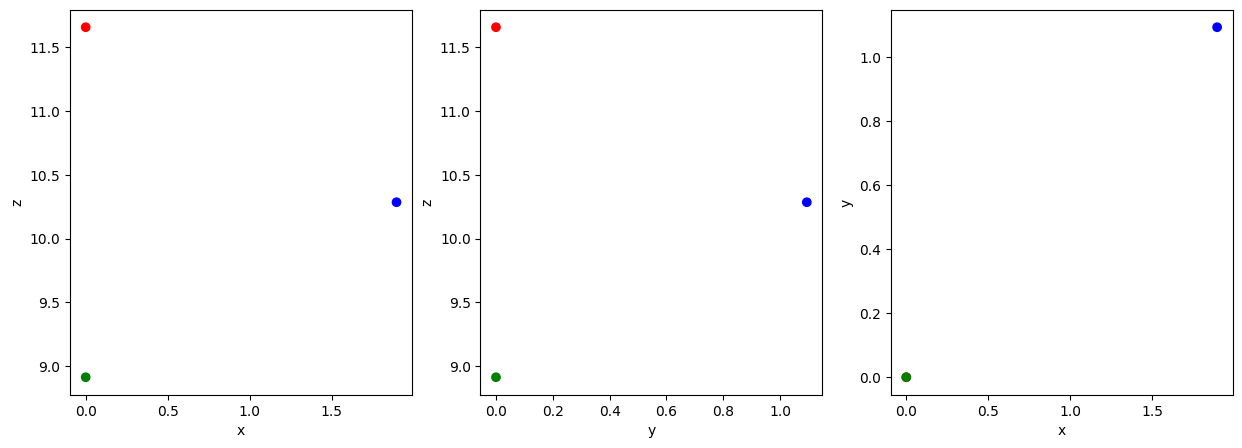

In [27]:
import matplotlib.pyplot as plt

coords = dh.xyz[-3:]


plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(coords[:, 0], coords[:, 2], color=["r", "g", "b"])
plt.xlabel("x")
plt.ylabel("z")
plt.subplot(132)
plt.scatter(coords[:, 1], coords[:, 2], color=["r", "g", "b"])
plt.xlabel("y")
plt.ylabel("z")
plt.subplot(133)
plt.scatter(coords[:, 0], coords[:, 1], color=["r", "g", "b"])
plt.xlabel("x")
plt.ylabel("y")
print("xyz[-3:]: red, green, blue")